In [2]:
import os
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from src.models.train_model import MonteCarloDropout, MCLSTM

plt.style.use('ggplot')

In [4]:
model_name = r"merged-ce-mc.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

model = keras.models.load_model(model_path, custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_train = combined_data['event_X_train']
object_X_train = combined_data['object_X_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [5]:
from src.features.build_features import scale_event_data, scale_object_data

event_X_train, event_X_test = scale_event_data(event_X_train, event_X_test)
object_X_train, object_X_test = scale_object_data(object_X_train, object_X_test)

In [63]:
def generate_sample():
    n = np.random.randint(0, event_X_test.shape[0])
    sample = [event_X_test.iloc[n:n+1].values, object_X_test[n:n+1]]
    y_true = y_test.iloc[n:n+1].values
    return (sample, y_true)


def predict_dist(X, model, n_models):
    preds = [model(X, training=False) for _ in tqdm(range(n_models))]
    return np.hstack(preds)


def plot_dist(sample, model, n_models, y_true):
    y_pred_dist = predict_dist(sample, model, n_models)
    y_pred = y_pred_dist.mean(axis=1)
    
    event_type = 'Signal' if y_true == [1] else 'Background'

    plt.figure(figsize=(10, 8))
    plt.xlim([0, 1])
    plt.xlabel('Discriminator Output')
    plt.title(f'Model Prediction Distribution for a Random {event_type} Event')
    sns.kdeplot(y_pred_dist[0], shade=True)
    plt.axvline(y_pred[0])
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

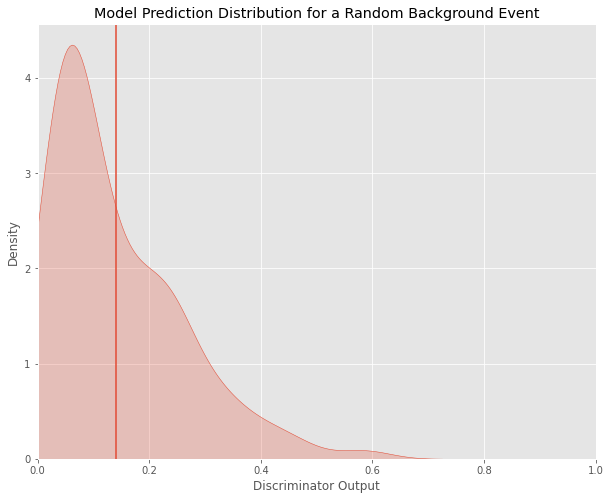

In [67]:
n_models = 100

sample, y_true = generate_sample()
plot_dist(sample, model, n_models, y_true)

In [6]:
n_samples = 1000
n_models = 10
errors = []
true_vals = []

def predict_sample(X, model, n_models):
    preds = [model(X, training=False) for _ in range(n_models)]
    mean = sum(preds) / len(preds)
    mean = float(mean[0][0])
    std = np.std(preds)
    return (mean, std)

def make_error_df(errors):
    error_df = pd.DataFrame(errors, columns=['model output', 'std'])
    true_vals_expanded = [i[0] for i in true_vals]
    error_df['event type'] = true_vals_expanded
    error_df['prediction error'] = np.abs(error_df['model output'] - error_df['event type'])
    error_df.replace(to_replace=[0, 1], value=['background', 'signal'], inplace=True)
    return error_df

def plot_output_error(error_df):
    plt.figure(figsize=(8, 8))
    plt.title('Error vs Discriminator Output')
    sns.scatterplot(x='model output', y='std', hue='event type', data=error_df, s=12, x_bins=10)

In [7]:
for _ in tqdm(range(n_samples)):
    sample, y_true = generate_sample()
    true_vals.append(y_true)
    error = predict_sample(sample, model, n_models)
    errors.append(error)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
error_df[error_df['event type'] == 'background'].mean()

C:\Users\Noaja\AppData\Local\Temp\ipykernel_16732\4188962606.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  error_df[error_df['event type'] == 'background'].mean()


1.760221475871429e-17

Average Uncertainty: 0.0948
Correlation Between Predicted Error and Actual Error: 0.4826


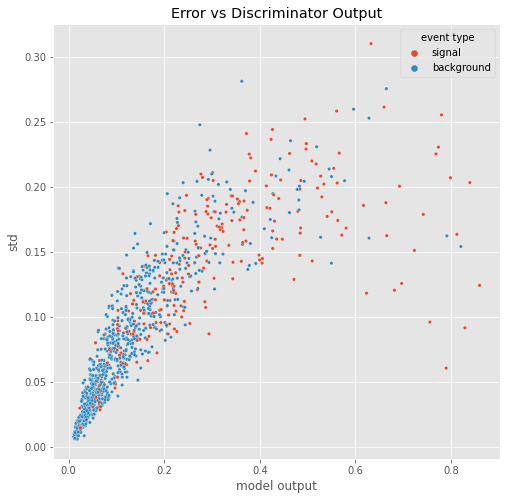

In [8]:
error_df = make_error_df(errors)
average_std = np.mean(error_df['std'])
correlation = error_df['prediction error'].corr(error_df['std'])

print(f'Average Uncertainty: {average_std:.4f}\nCorrelation Between Predicted Error and Actual Error: {correlation:.4f}')
plot_output_error(error_df)

In [40]:
correlation = error_df[error_df['event type'] == 'background']['prediction error'].corr(error_df['std'])
correlation

0.8592416898783002

c:\Users\Noaja\Downloads\msci_project\tth-ML-project\venv\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


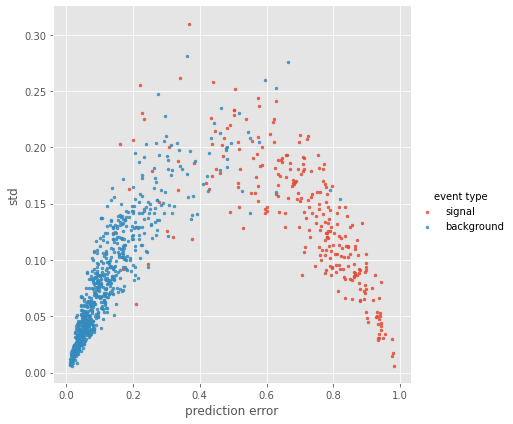

In [38]:
def plot_prediction_error(error_df):
    sns.lmplot(x='prediction error', 
               y='std', 
               hue='event type', 
               data=error_df,                
               size=6, 
               scatter_kws={"s": 6},
               fit_reg=False,
               )

plot_prediction_error(error_df)

In [1]:
# calculates the correlation between predicted error and actual error without mc dropout as a comparison
errors = []
true_vals = []
preds = []
n_samples = 1000

# loads non-MC model
model_name = r"merged-ce.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
model_path = os.path.join(model_path, model_name)
model_no_mc = keras.models.load_model(model_path, custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

for _ in tqdm(range(n_samples)):
    sample, y_true = generate_sample()
    pred = float(model_no_mc.predict(sample))
    error = np.abs(pred - y_true[0])
    true_vals.append(y_true[0])
    errors.append(error)
    preds.append(pred)

print(f'Correlation between prediction error and true values: {np.corrcoef(errors, true_vals)[0, 1]}')

NameError: name 'keras' is not defined